In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import cv2
import os
import subprocess
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from pathlib import Path
from collections import Counter


#import zipfile
#with zipfile.ZipFile('..input/data/dataset/multi_digit_images_10k.zip') 'r') as zip_ref:
#zip_ref.extractall('../input/data/dataset/multi_digit_images_10k/')
#I just want to use the 10k data for my project


I am not really good at English so....
Sr for not having time to shorten the code, you may find some silly things in this code.

You can find the code i use to generate picture of multi digit from MNSI dataset here:
https://www.kaggle.com/bomaich/multi-digit-images-generate-mnist
The following is the amount of pictures and some variables needed for the code to run (some are not needed :)) )

In [2]:
##############Preprocessing and preparing the images for training
# Path to the data directory
data_dir = Path("../input/dataset/multi_digit_images_40k/")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
# image chứa đường dẫn của image
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 128
img_height = 32

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

Number of images found:  40000
Number of labels found:  40000
Number of unique characters:  10
Characters present:  {'9', '6', '4', '7', '1', '8', '2', '0', '3', '5'}


#  Preprocessing and preparing the images for training
The images are loaded as grayscale and resized to width 128 and height 32. (orginal shape is 196x28)
Transpose the image and standardization
The image is then normalized to range [0, 1]
Reference: https://www.kaggle.com/samfc10/handwriting-recognition-using-crnn-in-keras

In [3]:
def preprocess(img, imgSize ):
    ''' resize, transpose and standardization grayscale images '''
    # create target image and copy sample image into it
    widthTarget, heightTarget = imgSize 
    height, width = img.shape 
    factor_x = width / widthTarget
    factor_y = height / heightTarget

    factor = max(factor_x, factor_y)
    # scale according to factor
    newSize = (min(widthTarget, int(width / factor)), min(heightTarget, int(height / factor)))

    img = cv2.resize(img, newSize)
    target = np.ones(shape=(heightTarget, widthTarget), dtype='uint8') * 255
    target[0:newSize[1], 0:newSize[0]] = img
    # transpose
    img = cv2.transpose(target)
    # standardization
    mean, stddev = cv2.meanStdDev(img)
    mean = mean[0][0]
    stddev = stddev[0][0]
    img = img - mean
    img = img // stddev if stddev > 0 else img
    return img

In [4]:
train_size = int(0.8 * len(labels))
valid_size= int(len(labels) - train_size)
# 80% data is for training. The rest of them is for validation

print ('\ntrain_size',train_size,'  valid_size',valid_size)


train_size 32000   valid_size 8000



 train_x.shape (32000, 128, 32, 1)

 valid_x.shape (8000, 128, 32, 1)

 Example of label_valid 7931983


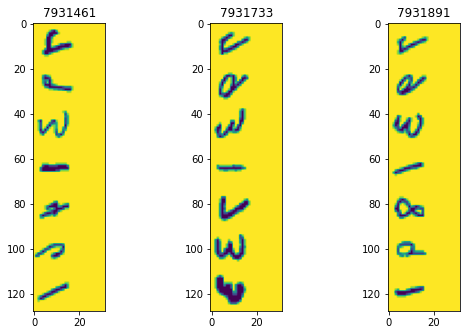

In [5]:
train_x = []
valid_x = []
i=0
for image in images:
    image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image, (128,32)) 
    image = image/255.
    if i < train_size:
        train_x.append(image)
    else:
        valid_x.append(image)
    i = i+1

train_x = np.array(train_x).reshape(-1, 128, 32, 1)
valid_x = np.array(valid_x).reshape(-1, 128, 32, 1)

print ('\n train_x.shape',train_x.shape)
print ('\n valid_x.shape',valid_x.shape)

label_train = labels[0:train_size]
label_valid = labels[train_size:len(labels)]
# They usually slit images into 2 folders, but I just have 1 so I have to label it again.

#print ('\n label_train',label_train)
print('\n Example of label_valid',label_valid[3])

plt.figure(num='multi digit',figsize=(9,18))
for i in range(3):
    plt.subplot(3,3,i+1) 
    plt.title(label_valid[i])
    plt.imshow(np.squeeze(valid_x[i,:,:,]))
plt.show()


# Preparing the labels for CTC Loss
Learn more about CTC loss and why its amazing for text recognition from here.

The labels have to be converted to numbers which represent each character in the training set. The 'alphabets' consist of A-Z and three special characters (- ' and space).

In [6]:
alphabets = u"0123456789' "
max_str_len = 10 # max length of input labels
# My project have 7 digits per image, but as long as the max_str_len > the number of digit per image, 
#it's just fine
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 32 # max length of predicted labels
# I find out that if the num_of_timestamps ... I forgot it... 

def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

name = '39816931'
print(name, '\n',label_to_num(name))

39816931 
 [3 9 8 1 6 9 3 1]


* train_y contains the true labels converted to numbers and padded with -1. The length of each label is equal to max_str_len.
* train_label_len contains the length of each true label (without padding)
* train_input_len contains the length of each predicted label. The length of all the predicted labels is constant i.e number of timestamps - 2.
* train_output is a dummy output for ctc loss.

In [7]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(label_train[i])
    train_y[i, 0:len(label_train[i])]= label_to_num(label_train[i])  
    

valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(label_valid[i])
    valid_y[i, 0:len(label_valid[i])]= label_to_num(label_valid[i])   

print('\n True label_train  : ',label_train[10] , '\ntrain_y : ',train_y[10],
      '\ntrain_label_len : ',train_label_len[10], '\ntrain_input_len : ', train_input_len[10])

print('\n True label_valid : ',label_valid[10] , '\ntrain_y : ',valid_y[10],
      '\ntrain_label_len : ',valid_label_len[10], '\ntrain_input_len : ', valid_input_len[10])



 True label_train  :  0002176 
train_y :  [ 0.  0.  0.  2.  1.  7.  6. -1. -1. -1.] 
train_label_len :  [7.] 
train_input_len :  [30.]

 True label_valid :  7934518 
train_y :  [ 7.  9.  3.  4.  5.  1.  8. -1. -1. -1.] 
train_label_len :  [7.] 
train_input_len :  [30.]


# Build the model
My funtional model is quite different from the original above because it's here:
https://keras.io/examples/vision/captcha_ocr/
But the final model is the same
yeah I had some trouble with the CTC inputs and outputs of catpcha

In [8]:
#y_true: tensor (samples, max_string_length) containing the truth labels.
#y_pred: tensor (samples, time_steps, num_categories) containing the prediction, or output of the softmax.
#input_length: tensor (samples, 1) containing the sequence length of slices coming out from RNN for each batch item in y_pred.
#label_length: tensor (samples, 1) containing the sequence length of label for each batch item in y_true.


def build_model(img_width = 128,img_height = 32, max_str_len = 10):
    # Inputs to the model

    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    y_pred = layers.Dense(10 + 1, activation="softmax", name="dense2")(x) # y pred
    model = keras.models.Model(inputs=input_img, outputs=y_pred, name="functional_1")

    def ctc_lambda_func(args):
        y_pred, labels, input_length, label_length = args
        # the 2 is critical here since the first couple outputs of the RNN
        # tend to be garbage
        y_pred = y_pred[:, 2:, :]
        return tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)

    labels = layers.Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
    input_length = layers.Input(name='input_length', shape=[1], dtype='int64')
    label_length = layers.Input(name='label_length', shape=[1], dtype='int64')

    ctc_loss = keras.layers.Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
    model_final = keras.models.Model(inputs=[input_img, labels, input_length, label_length], outputs=ctc_loss, name = "ocr_model_v1")
    
    return model, model_final

model, model_final = build_model()
model.summary()
model_final.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 128, 32, 1)]      0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 128, 32, 32)       320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 64, 16, 32)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 64, 16, 64)        18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 32, 8, 64)         0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 512)           0         
_________________________________________________________________
dense1 (Dense)               (None, 32, 64)           

You may ask why we need 2 models. The final with CTC is for training.
The functional is for saving and predicting.
The detail is in the comment here
https://www.kaggle.com/samfc10/handwriting-recognition-using-crnn-in-keras/comments

# Training


In [9]:
opt = keras.optimizers.Adam()

early_stopping_patience = 5
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=keras.optimizers.Adam(lr = 0.0001))

model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=60, 
                batch_size=128)


Epoch 1/60
250/250 [==============================] - 37s 102ms/step - loss: 30.9375 - val_loss: 18.4869
Epoch 2/60
250/250 [==============================] - 24s 97ms/step - loss: 17.7621 - val_loss: 19.0707
Epoch 3/60
250/250 [==============================] - 26s 102ms/step - loss: 17.6984 - val_loss: 19.3892
Epoch 4/60
250/250 [==============================] - 24s 97ms/step - loss: 17.6705 - val_loss: 19.6467
Epoch 5/60
250/250 [==============================] - 25s 99ms/step - loss: 17.6401 - val_loss: 19.3813
Epoch 6/60
250/250 [==============================] - 25s 102ms/step - loss: 17.6123 - val_loss: 19.3968
Epoch 7/60
250/250 [==============================] - 25s 102ms/step - loss: 17.5631 - val_loss: 19.7727
Epoch 8/60
250/250 [==============================] - 24s 96ms/step - loss: 17.2619 - val_loss: 18.4329
Epoch 9/60
250/250 [==============================] - 25s 102ms/step - loss: 16.1593 - val_loss: 17.6075
Epoch 10/60
250/250 [==============================] - 25s 

In [10]:
model.save('/kaggle/working/mymodel')

<a href="mymodel"> Download File </a>

# Some prediction on valid set

In [11]:
preds = model.predict(valid_x)
#print('\n preds',preds)
decoded = tf.keras.backend.get_value(tf.keras.backend.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])
print ('\n decoded',decoded)
prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))
    
print ('\n predict',num_to_label(decoded[0]))
y_true = label_valid
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))




 decoded [[ 7  7  3 ... -1 -1 -1]
 [ 7  9  3 ... -1 -1 -1]
 [ 7  9  3 ... -1 -1 -1]
 ...
 [ 7  4  9 ... -1 -1 -1]
 [ 7  4  9 ... -1 -1 -1]
 [ 7  9  9 ... -1 -1 -1]]

 predict 7731461
Correct characters predicted : 42.14%
Correct words predicted      : 2.66%


# Predict on some test image
I wil load some image and test


 filename 9232361.png

 filename 7513347.png

 filename 2631986.png

 filename 6612911.png

 filename 4949395.png

 filename 4154733.png


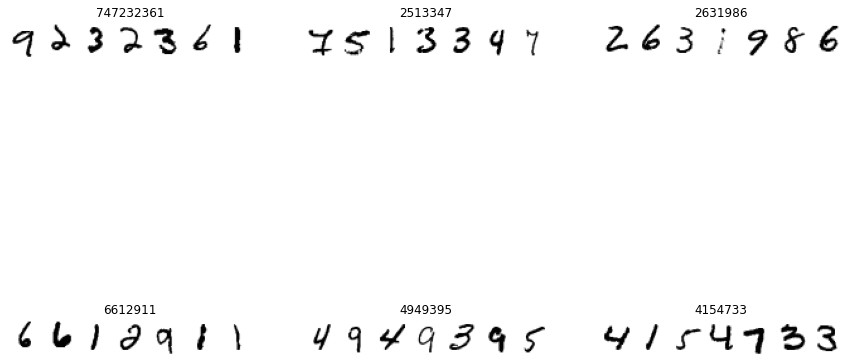

In [12]:
import random
plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    fold_dir = '../input/dataset/multi_digit_images_10k/multi_digit_images/'
    filename = random.sample((os.listdir(fold_dir)),1)
    filename = ( "".join( str(e) for e in filename ) ) # bỏ ngoặc
    print ('\n filename',filename)
    img_dir = fold_dir+str(filename) 
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    image = preprocess(image,(128,32))
    image = image/255.
    pred = model.predict(image.reshape(1, 128, 32, 1))
    decoded = tf.keras.backend.get_value(tf.keras.backend.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])

    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
